**Random Forest with TF-IDF**

In [ ]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import seaborn as sns
import numpy as np
import torch
from tqdm import tqdm
import joblib
import spacy
nltk.download("punkt")
nltk.download("punkt_tab")
nlp = spacy.load("en_core_web_sm")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ghanc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ghanc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
df = pd.read_csv("scraped_headlines.csv")
df["title"] = df["title"].str.strip().str.lower()


# Using Custom Stopwords created during EDA part

In [ ]:
with open("custom_stopwords.txt", "r") as f:
    custom_stopwords = set(line.strip() for line in f)

In [ ]:
X_text = df["title"]
y = df["label"]

In [ ]:
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
vectorizer = TfidfVectorizer(
    stop_words=list(custom_stopwords),
    max_features=5000,
    ngram_range=(1, 2),
)
X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

# **Random Forest with Default Setting**

In [ ]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred = rf_model.predict(X_test)


In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["NBC", "FoxNews"]))

Classification Report:
              precision    recall  f1-score   support

         NBC       0.74      0.79      0.77       495
     FoxNews       0.78      0.73      0.75       500

    accuracy                           0.76       995
   macro avg       0.76      0.76      0.76       995
weighted avg       0.76      0.76      0.76       995



In [ ]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Confusion Matrix:
[[393 102]
 [136 364]]


In [ ]:
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")


Accuracy: 0.7608


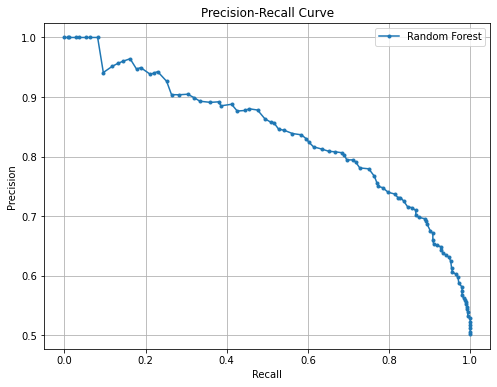

In [ ]:
y_scores = rf_model.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend()
plt.show()

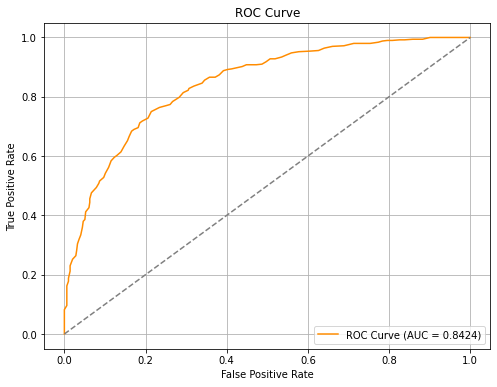

ROC-AUC Score: 0.8424


In [ ]:

fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"ROC-AUC Score: {roc_auc:.4f}")

# Top 20 Features contributing to Classification

In [ ]:
feature_names = vectorizer.get_feature_names_out()
importances = rf_model.feature_importances_

In [ ]:
top_n = 20
indices = np.argsort(importances)[::-1][:top_n]

print("Top words contributing to classification:")
for i in indices:
    print(f"{feature_names[i]}: {importances[i]:.5f}")

Top words contributing to classification:
harris: 0.01316
us: 0.01304
best: 0.01146
jan: 0.00990
trump: 0.00921
biden: 0.00882
gaza: 0.00727
cnn: 0.00673
says: 0.00601
dem: 0.00513
according: 0.00496
america: 0.00483
israel: 0.00468
israeli: 0.00443
american: 0.00437
election: 0.00436
kamala: 0.00433
history: 0.00431
reveals: 0.00431
capitol: 0.00408


# **Comparing Training V/S Validation Performance for each Parameter**

In [ ]:
param_range = [10, 50, 100, 200, 300]
train_scores, val_scores = validation_curve(
    RandomForestClassifier(random_state=42),
    X_train, y_train,
    param_name="n_estimators",
    param_range=param_range,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)


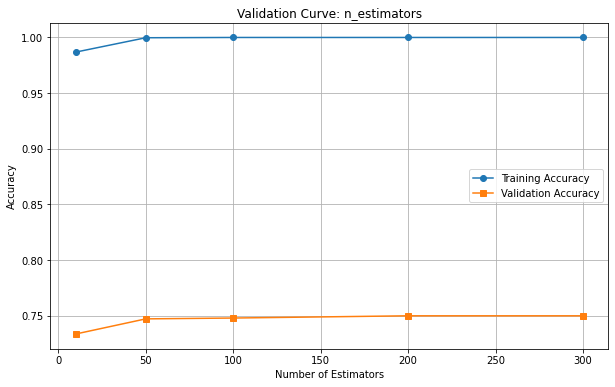

In [ ]:
train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label="Training Accuracy", marker='o')
plt.plot(param_range, val_mean, label="Validation Accuracy", marker='s')
plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy")
plt.title("Validation Curve: n_estimators")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
depth_range = [2, 5, 10, 20, 30, 50, None]
train_scores, val_scores = validation_curve(
    RandomForestClassifier(random_state=42, n_estimators=200),
    X_train, y_train,
    param_name="max_depth",
    param_range=depth_range,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

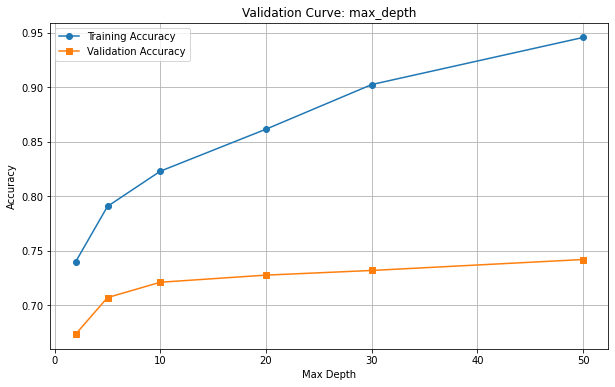

In [ ]:
train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(depth_range, train_mean, label="Training Accuracy", marker='o')
plt.plot(depth_range, val_mean, label="Validation Accuracy", marker='s')
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.title("Validation Curve: max_depth")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
split_range = [2, 5, 7, 8]
train_scores, val_scores = validation_curve(
    RandomForestClassifier(random_state=42, n_estimators=200),
    X_train, y_train,
    param_name="min_samples_split",
    param_range=split_range,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

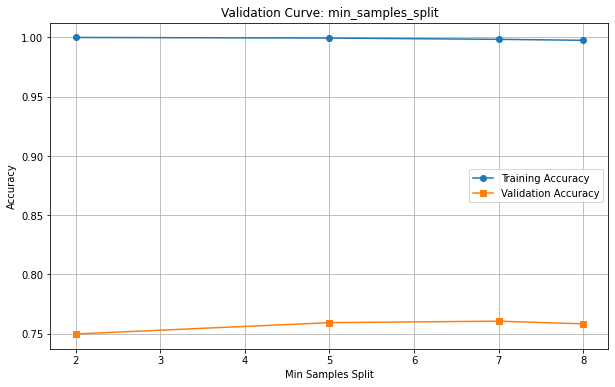

In [ ]:
train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(split_range, train_mean, label="Training Accuracy", marker='o')
plt.plot(split_range, val_mean, label="Validation Accuracy", marker='s')
plt.xlabel("Min Samples Split")
plt.ylabel("Accuracy")
plt.title("Validation Curve: min_samples_split")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
leaf_range = [2, 5, 7, 8]
train_scores, val_scores = validation_curve(
    RandomForestClassifier(random_state=42, n_estimators=200),
    X_train, y_train,
    param_name="min_samples_leaf",
    param_range=leaf_range,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

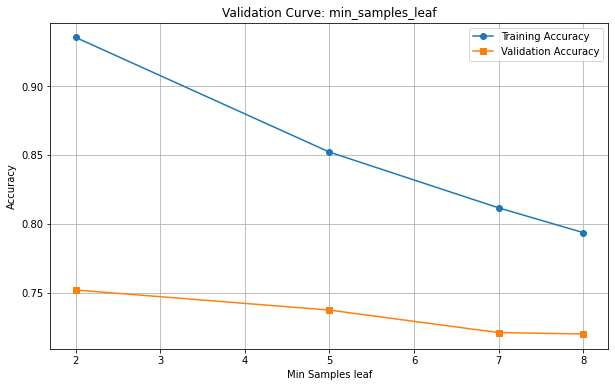

In [ ]:
train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(leaf_range, train_mean, label="Training Accuracy", marker='o')
plt.plot(leaf_range, val_mean, label="Validation Accuracy", marker='s')
plt.xlabel("Min Samples leaf")
plt.ylabel("Accuracy")
plt.title("Validation Curve: min_samples_leaf")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# param_grid = {
#     "n_estimators": [50, 70, 100, 200],
#     "max_depth": [10, 20, 30, 40],
#     "min_samples_split": [2, 5, 7],
#     "min_samples_leaf": [1, 2, 4]
# }

# rf = RandomForestClassifier(random_state=42)

# Grid Search With K Fold Validation

In [ ]:
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [40, 50, 60],
    "min_samples_split": [2, 5, 7],
    "min_samples_leaf": [1, 2],
    "max_features": ['sqrt', 'log2'],
}

rf = RandomForestClassifier(random_state=42)

In [ ]:
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [40, 50, 60],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5, 7],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=1)

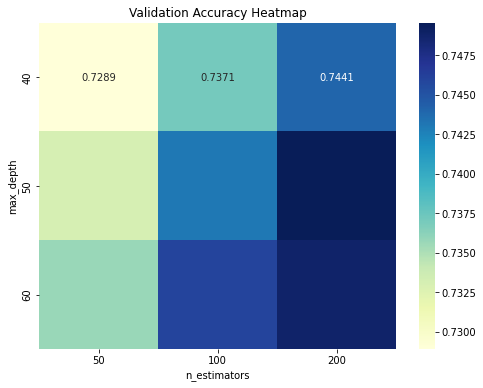

In [ ]:
cv_results = pd.DataFrame(grid_search.cv_results_)

pivot_table = cv_results.pivot_table(
    index='param_max_depth',
    columns='param_n_estimators',
    values='mean_test_score'
)

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap="YlGnBu")
plt.title("Validation Accuracy Heatmap")
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.show()

In [ ]:
print("Best Parameters Found:")
print(grid_search.best_params_)
print(f"Best CV Accuracy: {grid_search.best_score_:.4f}")

Best Parameters Found:
{'max_depth': 50, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best CV Accuracy: 0.7642


In [ ]:
final_rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=50,
    min_samples_split=5,
    min_samples_leaf=1,
    random_state=42,
    max_features= 'log2',
)
final_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=50, max_features='log2', min_samples_split=5,
                       n_estimators=200, random_state=42)

In [ ]:
y_pred_final = final_rf.predict(X_test)
print("Model Performance on Test Set:")
print(classification_report(y_test, y_pred_final))
print("Accuracy:", accuracy_score(y_test, y_pred_final))

Model Performance on Test Set:
              precision    recall  f1-score   support

           0       0.73      0.79      0.76       495
           1       0.78      0.71      0.74       500

    accuracy                           0.75       995
   macro avg       0.75      0.75      0.75       995
weighted avg       0.75      0.75      0.75       995

Accuracy: 0.7507537688442211


<Figure size 432x360 with 0 Axes>

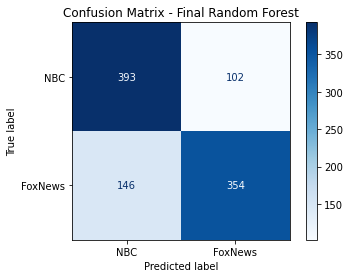

In [ ]:
cm = confusion_matrix(y_test, y_pred_final)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NBC", "FoxNews"])

plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Final Random Forest")
plt.show()

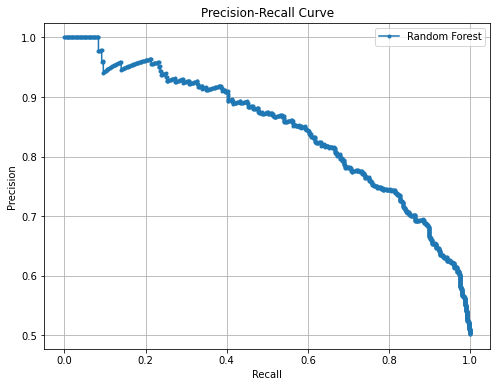

In [ ]:
y_scores = final_rf.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend()
plt.show()

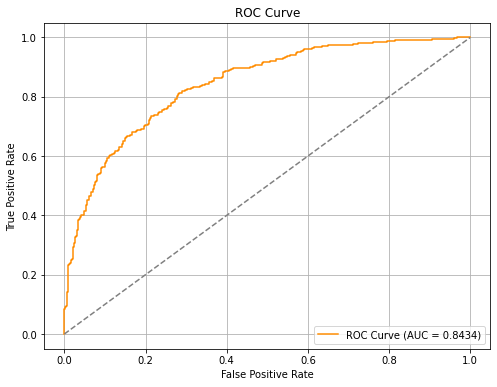

ROC-AUC Score: 0.8434


In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"ROC-AUC Score: {roc_auc:.4f}")

# Testing on Test Data provided

In [ ]:
joblib.dump(vectorizer, "tfidf_vectorizer_rf.pkl")
joblib.dump(final_rf,    "final_rf_tfidf.pkl")

['final_rf_tfidf.pkl']

In [ ]:
unseen_df = pd.read_csv("news_testData_randomSubset.csv")

In [ ]:
vectorizer = joblib.load("tfidf_vectorizer_rf.pkl")
model      = joblib.load("final_rf_tfidf.pkl")

In [ ]:
X_unseen = (
    unseen_df["Headline"]
      .str.strip()
      .str.lower()
)

X_unseen_tfidf = vectorizer.transform(X_unseen)

In [ ]:
preds_num = model.predict(X_unseen_tfidf)

unseen_df['Label(FoxNews/NBC)'] = ["FoxNews" if p == 1 else "NBC" for p in preds_num]

In [ ]:
counts = unseen_df["Label(FoxNews/NBC)"].value_counts()
print(counts)

Label(FoxNews/NBC)
NBC        619
FoxNews    554
Name: count, dtype: int64


In [ ]:
unseen_df.to_csv("Final_predictions_RF.csv", index=False)